In [3]:
import cv2
import numpy as np
import pandas as pd
import bokeh.palettes

from inference import Network
from model_handlers import handle_output
from image_handlers import preprocessing
from matplotlib import pyplot as plt


In [107]:
class Models:
  def __init__(self, ident, src, out_c):
    self.id = ident
    self.src = src
    self.out_c = out_c
    self.network = Network()
  def load_model(self, InfDevice, InfCPUExt):
    n, self.in_c, self.in_h, self.in_w = self.network.load_model(self.src, InfDevice, InfCPUExt)
  def run_inference(self, preprocessed_frame):
    self.network.sync_inference(preprocessed_frame)
    return self.network.extract_output()

###### Auxiliary Functions ######

def calc_JointPosition(JointHeatmap):
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(JointHeatmap)
    return max_loc

def HexToBGR(HexColor):
    h=HexColor.lstrip('#')
    R,G,B= tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return (B,G,R,30)

def pathToName(path = "out.mp4"):
    x = path.split("/")
    return x[-1].split(".")[0]

def skeleton_creator(HexColorPalette = None):
    #index for multipose model
    ixn=['head','neck','right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist',
         'right_hip','right_knee','right_foot','left_hip','left_knee','left_foot',
         'right_eye','left_eye','right_ear', 'left_ear', 'indet']
    n=len(ixn)
    ixMultiPose=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
    ixSinglePose=np.array([0,None,6,8,10,5,7,9,12,14,16,11,13,15,2,1,4,3,None])

    baseColor=[]
    hexColor=[]
    if HexColorPalette==None:
        for p in range(n):
            baseColor.append(( 0, 200, 200)) # default color if no palette
            hexColor.append("#00c8c8") # default hex color
    else:
        #should be a 5 row hex color palette
        colorArr=HexColorPalette
        baseColor=[HexToBGR(colorArr[2]), HexToBGR(colorArr[2]),
                   HexToBGR(colorArr[1]),HexToBGR(colorArr[1]),HexToBGR(colorArr[1]),
                   HexToBGR(colorArr[0]),HexToBGR(colorArr[0]),HexToBGR(colorArr[0]),
                   HexToBGR(colorArr[4]),HexToBGR(colorArr[4]),HexToBGR(colorArr[4]),
                   HexToBGR(colorArr[3]),HexToBGR(colorArr[3]),HexToBGR(colorArr[3]),
                   HexToBGR(colorArr[1]),HexToBGR(colorArr[0]),
                   HexToBGR(colorArr[1]), HexToBGR(colorArr[0]), (0,0,0)]
        hexColor=[colorArr[2], colorArr[2], colorArr[1], colorArr[1], colorArr[1],
                   colorArr[0], colorArr[0], colorArr[0], colorArr[4], colorArr[4], colorArr[4],
                   colorArr[3], colorArr[3], colorArr[3], colorArr[1], colorArr[0],
                   colorArr[1], colorArr[0], "#0f0f0f"]
    data = {'SINGLEPOSE':ixSinglePose, 'MULTIPOSE': ixMultiPose, 'baseColor':baseColor, 'hexColor':hexColor} 
    return pd.DataFrame(data, index=ixn)


In [75]:
##### Skeleton Drawing ######

def calcMiddlePoint(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (min(x1,x2)+int(abs(x2-x1)/2), min(y1,y2)+int(abs(y2-y1)/2))
def calcDistance(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (int(abs(x2-x1))**2 + int(abs(y2-y1))**2)**0.5

#Generates frame with skeleton with OpenCV
def genCV_Skeleton(skeleton, skelCoords, frame, darkmode=True):
    colorIx=skeleton['baseColor']
    bLineColor=colorIx['head']
    imout = np.zeros(frame.shape, dtype=np.int8)

    if not(skelCoords.loc['right_eye']==(0,0) or skelCoords.loc['left_eye']==(0,0)):
        cv2.line(imout, skelCoords.loc['right_eye'], skelCoords.loc['left_eye'], bLineColor,5)
        cv2.circle(imout, skelCoords.loc['right_eye'], 7, colorIx['right_eye'],5)
        cv2.circle(imout, skelCoords.loc['left_eye'], 7, colorIx['left_eye'],5)
        if (skelCoords.loc['head']!=(0,0)):
            cv2.line(imout, skelCoords.loc['right_eye'], skelCoords.loc['head'], bLineColor,5)
            cv2.line(imout, skelCoords.loc['left_eye'], skelCoords.loc['head'], bLineColor,5)

    if (skelCoords.loc['head']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['head'], 7, colorIx['head'],5)

    pelvis=(0,0)
    if (skelCoords.loc['left_hip']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['left_hip'], 7, colorIx['left_hip'],5)
        if (skelCoords.loc['right_hip']!=(0,0)):
            pelvis = calcMiddlePoint(skelCoords.loc['left_hip'],skelCoords.loc['right_hip'])
            cv2.line(imout, skelCoords.loc['left_hip'], skelCoords.loc['right_hip'], bLineColor,5)
    if (skelCoords.loc['right_hip']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['right_hip'], 7, colorIx['right_hip'],5)

    #headRad=int(calcDistance(skelCoords.loc['left_shoulder'],skelCoords.loc['right_shoulder'])/4)+3
    if not(skelCoords.loc['left_shoulder']==(0,0) or skelCoords.loc['right_shoulder']==(0,0)):
        cv2.line(imout, skelCoords.loc['left_shoulder'], skelCoords.loc['right_shoulder'], bLineColor,5)
        neck = calcMiddlePoint(skelCoords.loc['left_shoulder'],skelCoords.loc['right_shoulder'])
        if (skelCoords.loc['head']!=(0,0)):
            cv2.line(imout, skelCoords.loc['head'], neck, bLineColor,5)
        if (pelvis!=(0,0)):
            cv2.line(imout, pelvis, skelCoords.loc['left_shoulder'], bLineColor,5)
            cv2.line(imout, pelvis, skelCoords.loc['right_shoulder'], bLineColor,5)

    if (skelCoords.loc['left_wrist']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['left_wrist'], 7, colorIx['left_wrist'],5)
        if (skelCoords.loc['left_elbow']!=(0,0)):
            cv2.line(imout, skelCoords.loc['left_elbow'], skelCoords.loc['left_wrist'], bLineColor,5)
            cv2.circle(imout, skelCoords.loc['left_elbow'], 7, colorIx['left_elbow'],5)
    if (skelCoords.loc['left_shoulder']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['left_shoulder'], 7, colorIx['left_shoulder'],5)
        if (skelCoords.loc['left_elbow']!=(0,0)):
            cv2.line(imout, skelCoords.loc['left_shoulder'], skelCoords.loc['left_elbow'], bLineColor,5)

    if (skelCoords.loc['right_wrist']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['right_wrist'], 7, colorIx['right_wrist'],5)
        if (skelCoords.loc['right_elbow']!=(0,0)):
            cv2.line(imout, skelCoords.loc['right_elbow'], skelCoords.loc['right_wrist'], bLineColor,5)
            cv2.circle(imout, skelCoords.loc['right_elbow'], 7, colorIx['right_elbow'],5)
    if (skelCoords.loc['right_shoulder']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['right_shoulder'], 7, colorIx['right_shoulder'],5)
        if (skelCoords.loc['right_elbow']!=(0,0)):
            cv2.line(imout, skelCoords.loc['right_shoulder'], skelCoords.loc['right_elbow'], bLineColor,5)

    if (skelCoords.loc['left_foot']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['left_foot'], 7, colorIx['left_foot'],5)
        if (skelCoords.loc['left_knee']!=(0,0)):
            cv2.line(imout, skelCoords.loc['left_knee'], skelCoords.loc['left_foot'], bLineColor,5)
            cv2.circle(imout, skelCoords.loc['left_knee'], 7, colorIx['left_knee'],5)
    if not(skelCoords.loc['left_hip']==(0,0) or skelCoords.loc['left_knee']==(0,0)):
        cv2.line(imout, skelCoords.loc['left_hip'], skelCoords.loc['left_knee'], bLineColor,5)        

    if (skelCoords.loc['right_foot']!=(0,0)):
        cv2.circle(imout, skelCoords.loc['right_foot'], 7, colorIx['right_foot'],5)
        if (skelCoords.loc['right_knee']!=(0,0)):
            cv2.line(imout, skelCoords.loc['right_knee'], skelCoords.loc['right_foot'], bLineColor,5)
            cv2.circle(imout, skelCoords.loc['right_knee'], 7, colorIx['right_knee'],5)
    if not(skelCoords.loc['right_hip']==(0,0) or skelCoords.loc['right_knee']==(0,0)):
        cv2.line(imout, skelCoords.loc['right_hip'], skelCoords.loc['right_knee'], bLineColor,5)
    
    if darkmode==True:
        return imout.astype('uint8')
    else:
        return cv2.add(imout.astype('uint8'),frame)
    

In [142]:
def genBokeh_Skeleton(skeleton, skelCoords):
    #coordinates & colors
    mySkeleton = pd.DataFrame(index=skeleton.index)
    mySkeleton['coord2d']=skelCoords
    mySkeleton['color']=skeleton["hexColor"]
    mySkeleton['name']=skeleton.index
    mySkeleton.index=np.arange(mySkeleton.shape[0])
    # build pelvis
    pelvis=(0,0)  
    pelvisix=mySkeleton.shape[0]
    if (skelCoords.loc['left_hip']!=(0,0)) and (skelCoords.loc['right_hip']!=(0,0)):
        pelvis = calcMiddlePoint(skelCoords.loc['left_hip'],skelCoords.loc['right_hip'])
    mySkeleton = mySkeleton.append({"name": "pelvis", "coord2d": pelvis,
                                   "color": mySkeleton.loc[0]['color']}, ignore_index=True) 
    mySkeleton = mySkeleton[mySkeleton.coord2d!=(0,0)] #filter undetected joints

    # graphbuilder- connections
    jSrc=[]
    jDst=[]
    jSrc.append(0)
    jDst.append(1)#head-neck
    jSrc.append(2)
    jDst.append(3)#right_shoulder - right_elbow
    jSrc.append(3)
    jDst.append(4)#right_elbow - right_wrist
    jSrc.append(5)
    jDst.append(6)#left_shoulder - left_elbow
    jSrc.append(6)
    jDst.append(7)#left_elbow - left_wrist
    jSrc.append(8)
    jDst.append(9)#right_hip - right_knee
    jSrc.append(9)
    jDst.append(10)#right_knee - right_foot
    jSrc.append(11)
    jDst.append(12)#left_hip - left_knee
    jSrc.append(12)
    jDst.append(13)#left_knee - left_foot
    jSrc.append(14)
    jDst.append(15)#right_eye - left_eye
    jSrc.append(14)
    jDst.append(1)#right_eye - head
    jSrc.append(15)
    jDst.append(1)#left_eye - head
    jSrc.append(5)
    jDst.append(2)#left_shoulder - right_shoulder
    jDst.append(2)
    jSrc.append(pelvisix)#right_shoulder - pelvis
    jDst.append(5)
    jSrc.append(pelvisix)#left_shoulder - pelvis
    jDst.append(8)
    jSrc.append(11)#right_hip - left_hip

    conns={'start':jSrc, 'end':jDst}
    return mySkeleton, conns

def cleanStrCoords(coords):
    if isinstance(coords, str):
        res=coords[1:-1].split(",")
        coords=(int(res[0]) , int(res[1]))
    return coords

In [76]:
###### Constants #######

spModel=Models("SINGLEPOSE","./models/single-human-pose-estimation-0001.xml", 17)
mpModel=Models("MULTIPOSE", "./models/human-pose-estimation-0001.xml", 19)
InfCPUExt=None
InfDevice="CPU"

#skColors = bokeh.palettes.brewer['Pastel1'][5]
skColors = bokeh.palettes.brewer['Dark2'][5]

videoFile="./videos/mov3.mp4"
videoOut="./videos/"+pathToName(videoFile)+"out.mp4"
csvOut="./videos/"+pathToName(videoFile)+".csv"
max_frames=1200
videoFPS=30

In [108]:
skeleton = skeleton_creator(skColors)

skeleton

,SINGLEPOSE,MULTIPOSE,baseColor,hexColor
head,0,0,"(179, 112, 117, 30)",#7570b3
neck,None,1,"(179, 112, 117, 30)",#7570b3
right_shoulder,6,2,"(2, 95, 217, 30)",#d95f02
right_elbow,8,3,"(2, 95, 217, 30)",#d95f02
right_wrist,10,4,"(2, 95, 217, 30)",#d95f02
left_shoulder,5,5,"(119, 158, 27, 30)",#1b9e77
left_elbow,7,6,"(119, 158, 27, 30)",#1b9e77
left_wrist,9,7,"(119, 158, 27, 30)",#1b9e77
right_hip,12,8,"(30, 166, 102, 30)",#66a61e
right_knee,14,9,"(30, 166, 102, 30)",#66a61e


In [78]:
jointCoords = pd.DataFrame(columns=skeleton.index)

jointCoords.describe()

,head,neck,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist,right_hip,right_knee,right_foot,left_hip,left_knee,left_foot,right_eye,left_eye,right_ear,left_ear,indet
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# init video or stream
capture = cv2.VideoCapture(videoFile, cv2.CAP_FFMPEG)
if (capture.isOpened() == False): 
    print("Unable to open video file")
#capture.set(cv2.CAP_PROP_POS_FRAMES, 50)
#post_frame = capture.get(cv2.CAP_PROP_POS_FRAMES)
print(post_frame)

50.0


Capture End


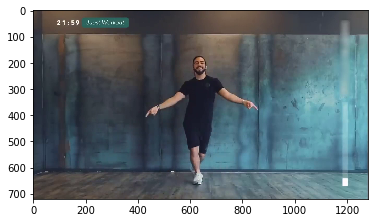

In [166]:
max_frames=10

# Grab frames
for i in range(0, max_frames):
    ret, frame = capture.read()
    if not ret:
        print("Can't receive frame (video end?). Exiting ...")
        break
capture.release()
print("Capture End")

im_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [81]:
#Find Statistical Joints, For each frame make inference

Model=mpModel

# Create a Network for using the Inference Engine
inference_network = Network()
# Load the model in the network, Read network input shape
n, Model.in_c, Model.in_h, Model.in_w = inference_network.load_model(Model.src, InfDevice, InfCPUExt)
# Read the input image
preprocessed_frame = preprocessing(frame, Model.in_h, Model.in_w)
# Perform synchronous inference on the image
inference_network.sync_inference(preprocessed_frame)
# Obtain the output of the inference request
raw_output = inference_network.extract_output()
#process output
processed_output = handle_output(Model.id)(raw_output, frame.shape)
Model.out_c, h, w = processed_output.shape


input shape:  [1, 3, 256, 456]


In [82]:
jointLayers=Model.out_c
#Find and Save Joint Coordinates 

poseDict={}
for joint in range(jointLayers):
    #selects correct joint name for selected model
    jointName=skeleton.index[skeleton[Model.id]==joint].values[0]
    #estimates position for joint (peak ~~ central position)
    poseDict[jointName] = calc_JointPosition(processed_output[joint])
print(poseDict)
#append for adding data ***** can be optimized by preallocating or dict injection
jointCoords = jointCoords.append(poseDict, ignore_index=True)    

#jointCoords

{'head': (639, 123), 'neck': (617, 191), 'right_shoulder': (572, 191), 'right_elbow': (527, 236), 'right_wrist': (527, 191), 'left_shoulder': (662, 191), 'left_elbow': (729, 258), 'left_wrist': (729, 191), 'right_hip': (595, 348), 'right_knee': (595, 461), 'right_foot': (595, 573), 'left_hip': (662, 348), 'left_knee': (640, 461), 'left_foot': (640, 573), 'right_eye': (617, 123), 'left_eye': (639, 123), 'right_ear': (595, 124), 'left_ear': (640, 145), 'indet': (0, 0)}


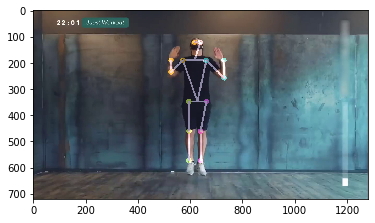

In [83]:
skelCoords=jointCoords.loc[0]
imout = genCV_Skeleton(skeleton, skelCoords, frame, False) 

cv2.imwrite("./output_net.png", imout)
im_rgb = cv2.cvtColor(imout, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [73]:
Model = mpModel
Model.load_model(InfDevice, InfCPUExt)

skeleton = skeleton_creator(skColors)
jointCoords = pd.DataFrame(columns=skeleton.index)
max_frames = 1200
frame = None

# init video or stream input & output
capture = cv2.VideoCapture(videoFile, cv2.CAP_FFMPEG)
codec = cv2.VideoWriter_fourcc('M','J','P','G')
outvideo = cv2.VideoWriter(videoOut, codec, videoFPS, (w, h))
if (capture.isOpened() == False): 
    print("Unable to open video file")

print("Process Start")
# Mean processing
for i in range(0, max_frames):
    #read frame
    ret, frame = capture.read()
    if not ret:
        print("Can't receive frame (video end?). Exiting ...")
        break
    #inference in model
    #if i%2==0: # skip odd frames
    preprocessed_frame = preprocessing(frame, Model.in_h, Model.in_w)
    raw_output = Model.run_inference(preprocessed_frame)
    processed_output = handle_output(Model.id)(raw_output, frame.shape)
    #find and save joints
    poseDict={}
    for joint in range(Model.out_c):
        jointName = skeleton.index[skeleton[Model.id]==joint].values[0]
        poseDict[jointName] = calc_JointPosition(processed_output[joint])
    jointCoords = jointCoords.append(poseDict, ignore_index=True) 
    imout = genCV_Skeleton(skeleton, jointCoords.iloc[i], frame, False) 
    outvideo.write(imout)
capture.release()
outvideo.release()
print("Process Ended, frames:", i+1)


input shape:  [1, 3, 256, 456]
Process Start
Can't receive frame (video end?). Exiting ...
Process Ended, frames: 532


In [71]:
jointCoords.to_csv(csvOut,sep=";",index=True,header=True)
jointCoords

,head,neck,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist,right_hip,right_knee,right_foot,left_hip,left_knee,left_foot,right_eye,left_eye,right_ear,left_ear,indet
0,"(685, 213)","(684, 281)","(639, 281)","(595, 348)","(617, 281)","(729, 281)","(774, 348)","(774, 280)","(640, 439)","(572, 551)","(527, 641)","(707, 438)","(797, 528)","(841, 663)","(684, 213)","(707, 213)","(662, 213)","(707, 235)","(0, 0)"
1,"(729, 213)","(685, 281)","(640, 281)","(639, 348)","(662, 281)","(751, 281)","(819, 326)","(819, 258)","(640, 438)","(572, 551)","(527, 641)","(707, 438)","(819, 528)","(841, 663)","(707, 213)","(729, 191)","(684, 213)","(707, 213)","(0, 0)"
2,"(752, 213)","(707, 281)","(662, 281)","(684, 326)","(707, 280)","(752, 280)","(841, 326)","(842, 258)","(662, 438)","(572, 550)","(505, 619)","(729, 438)","(819, 528)","(841, 663)","(730, 191)","(752, 191)","(707, 213)","(751, 191)","(0, 0)"
3,"(774, 191)","(729, 259)","(685, 259)","(729, 326)","(774, 258)","(774, 259)","(842, 304)","(842, 258)","(662, 438)","(594, 528)","(505, 618)","(729, 438)","(819, 528)","(841, 663)","(752, 191)","(774, 191)","(729, 191)","(752, 191)","(0, 0)"
4,"(796, 191)","(751, 258)","(707, 258)","(774, 303)","(819, 258)","(774, 258)","(841, 303)","(841, 258)","(684, 416)","(595, 528)","(505, 596)","(730, 416)","(819, 506)","(841, 663)","(774, 190)","(797, 169)","(751, 191)","(752, 191)","(0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,"(707, 191)","(684, 258)","(639, 258)","(640, 303)","(685, 258)","(707, 258)","(797, 303)","(752, 258)","(618, 416)","(572, 528)","(527, 641)","(685, 416)","(774, 528)","(797, 663)","(685, 169)","(707, 169)","(662, 191)","(684, 258)","(0, 0)"
390,"(729, 190)","(685, 258)","(662, 236)","(684, 303)","(730, 258)","(729, 258)","(797, 303)","(775, 258)","(639, 416)","(572, 528)","(527, 619)","(707, 416)","(774, 528)","(797, 641)","(707, 168)","(729, 168)","(684, 191)","(729, 168)","(0, 0)"
391,"(751, 169)","(707, 236)","(684, 236)","(729, 281)","(774, 258)","(730, 258)","(797, 303)","(797, 258)","(640, 416)","(573, 528)","(505, 618)","(707, 415)","(774, 506)","(797, 641)","(729, 168)","(752, 168)","(707, 190)","(730, 168)","(0, 0)"
392,"(752, 168)","(707, 236)","(685, 236)","(774, 281)","(796, 236)","(729, 236)","(774, 281)","(796, 258)","(662, 415)","(594, 506)","(505, 618)","(707, 415)","(774, 506)","(797, 641)","(751, 168)","(752, 168)","(707, 169)","(729, 168)","(0, 0)"


In [30]:
##### Save video & Data #####
h,w,c = frame.shape
imout = np.zeros(frame.shape, dtype=np.int8)

codec = cv2.VideoWriter_fourcc('M','J','P','G')
outvideo = cv2.VideoWriter('output_net.mp4', codec, 30, (w, h))

for pose in range(len(jointCoords.index)):
    skelCoords=jointCoords.iloc[pose]
    imout = genCV_Skeleton(skeleton, skelCoords, frame) 
    outvideo.write(imout)
outvideo.release()
jointCoords.to_csv(csvOut,sep=";",index=True,header=True)


In [62]:
##### Opening joints data ######
mimo=pd.read_csv(csvOut,sep=";",index_col=0)  
mimo

,head,neck,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist,right_hip,right_knee,right_foot,left_hip,left_knee,left_foot,right_eye,left_eye,right_ear,left_ear,indet
0,"(617, 168)","(617, 258)","(572, 258)","(527, 326)","(527, 281)","(662, 258)","(707, 326)","(729, 281)","(595, 415)","(595, 528)","(595, 618)","(640, 415)","(640, 528)","(639, 618)","(617, 168)","(618, 168)","(595, 190)","(640, 190)","(0, 0)"
1,"(617, 168)","(617, 258)","(572, 258)","(527, 326)","(527, 281)","(662, 258)","(707, 326)","(729, 281)","(595, 415)","(595, 528)","(595, 618)","(640, 415)","(640, 528)","(639, 618)","(617, 168)","(618, 168)","(595, 190)","(640, 190)","(0, 0)"
2,"(617, 191)","(617, 258)","(572, 258)","(527, 325)","(505, 280)","(662, 258)","(729, 326)","(729, 280)","(595, 416)","(595, 528)","(617, 618)","(662, 416)","(640, 528)","(639, 618)","(617, 190)","(639, 190)","(595, 191)","(640, 191)","(0, 0)"
3,"(617, 190)","(617, 258)","(572, 258)","(505, 303)","(505, 258)","(662, 258)","(729, 303)","(729, 258)","(595, 416)","(595, 528)","(617, 618)","(662, 416)","(640, 528)","(639, 618)","(617, 168)","(639, 169)","(595, 191)","(640, 191)","(0, 0)"
4,"(617, 213)","(617, 236)","(572, 236)","(527, 281)","(505, 258)","(662, 236)","(729, 303)","(729, 236)","(595, 393)","(595, 506)","(595, 618)","(662, 393)","(640, 506)","(639, 618)","(617, 191)","(639, 191)","(595, 191)","(639, 191)","(0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,"(595, 168)","(595, 236)","(550, 258)","(504, 348)","(415, 393)","(662, 236)","(730, 303)","(819, 326)","(572, 416)","(482, 529)","(437, 664)","(640, 416)","(685, 550)","(707, 686)","(572, 168)","(595, 168)","(572, 168)","(617, 168)","(0, 0)"
527,"(594, 190)","(595, 258)","(549, 259)","(482, 348)","(415, 394)","(662, 258)","(729, 304)","(819, 348)","(550, 438)","(460, 551)","(437, 686)","(639, 438)","(684, 551)","(707, 686)","(572, 168)","(595, 168)","(550, 191)","(617, 190)","(0, 0)"
528,"(572, 191)","(594, 280)","(527, 281)","(460, 370)","(393, 415)","(640, 258)","(729, 326)","(797, 348)","(527, 438)","(460, 551)","(437, 686)","(617, 438)","(662, 551)","(707, 686)","(572, 190)","(594, 169)","(550, 191)","(617, 191)","(0, 0)"
529,"(572, 191)","(594, 280)","(527, 281)","(460, 370)","(393, 415)","(640, 258)","(729, 326)","(797, 348)","(527, 438)","(460, 551)","(437, 686)","(617, 438)","(662, 551)","(707, 686)","(572, 190)","(594, 169)","(550, 191)","(617, 191)","(0, 0)"


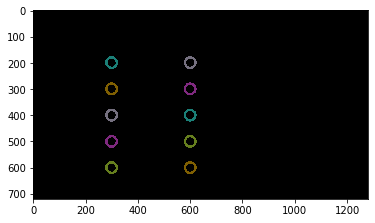

In [125]:
imout = np.zeros(frame.shape, dtype=np.int8)

skColors = bokeh.palettes.brewer['Dark2'][5]

cv2.circle(imout, (300,200), 20, HexToBGR(skColors[0]), 7)
cv2.circle(imout, (300,300), 20, HexToBGR(skColors[1]), 7)
cv2.circle(imout, (300,400), 20, HexToBGR(skColors[2]), 7)
cv2.circle(imout, (300,500), 20, HexToBGR(skColors[3]), 7)
cv2.circle(imout, (300,600), 20, HexToBGR(skColors[4]), 7)

cv2.circle(imout, (600,200), 20, colorIx['head'], 7)
cv2.circle(imout, (600,300), 20, colorIx['left_knee'], 7)
cv2.circle(imout, (600,400), 20, colorIx['left_elbow'], 7)
cv2.circle(imout, (600,500), 20, colorIx['right_knee'], 7)
cv2.circle(imout, (600,600), 20, colorIx['right_elbow'], 7)

im_rgb = cv2.cvtColor(imout.astype('uint8'), cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)